<a href="https://colab.research.google.com/github/IngeborgOlssoen/ECG-chagas/blob/main/Chagas_challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Content

1. Resumen
2. Setup
3. Helper functions
4. Dataplitting & Balancing of samples
5. Ensemble model (HearHeart)
6. S4 Model
7. Comparison between Ensemble Model and S4 model



#Resumen
En este proyecto, partimos del repositorio oficial de ejemplo en Python proporcionado para el George B. Moody PhysioNet Challenge 2025 (GitHub) para desarrollar y evaluar dos modelos distintos de aprendizaje automático con el objetivo de detectar la enfermedad de Chagas a partir de señales de ECG.

El primer enfoque es un modelo de ensamble, inspirado en la solución ganadora del Heart Murmur Detection Challenge 2022 (HearHeart). Este ensamble combina tres arquitecturas neuronales independientes: un clasificador basado en una red neuronal artificial (ANN), una red convolucional recurrente (CRNN) y un modelo basado en ResNet. Cada modelo se entrena de forma individual, y las predicciones finales se obtienen mediante un promedio ponderado de las probabilidades de salida de cada uno. Esta estrategia aprovecha las diferentes representaciones de características que aprende cada arquitectura para mejorar la robustez y el rendimiento del modelo.

El segundo modelo desarrollado se basa en la arquitectura S4 (Structured State Space Sequence), diseñada para modelar secuencias largas de forma eficiente. Esta arquitectura es especialmente adecuada para procesar señales de ECG multicanal y de larga duración, y ha sido ajustada para predecir directamente la probabilidad de Chagas en cada caso.

Ambos modelos fueron integrados dentro del entorno de evaluación oficial del Challenge, utilizando la función de puntuación proporcionada (compute_challenge_score) y evaluados con la misma metodología para permitir una comparación justa. Todo el flujo de trabajo —incluyendo carga de datos, preprocesamiento de señales, inferencia del modelo, formato de salida y evaluación de resultados— se documenta detalladamente en el notebook disponible en este enlace.

El modelo de ensamble mostró un rendimiento sólido gracias a la complementariedad de sus arquitecturas, mientras que el modelo S4 evidenció potencial para futuras mejoras mediante un ajuste más fino y técnicas de representación especializadas para señales fisiológicas.


# Repo setup

To run this notebook, we need to prepare a minimal working environment using a lightweight version of the dataset. This setup is designed for demonstration purposes and does not require full dataset access, making it suitable for evaluation of our models.

To be able to run the code:

1. Download a small test split from the original dataset to serve as a holdout set

2. Clone a GitHub repository

3. Add the repo to the Python path so their modules can be used directly





### Clone repository and locate it

In [ ]:
!git clone -b Slimmed-models https://github.com/IngeborgOlssoen/Chagas-challenge-Hear-heart.git
!cd Chagas-challenge-Hear-heart && ls

### Add them as system path

In [ ]:
import sys
sys.path.append('/content/Chagas-challenge-Hear-heart')

### Requirements and imports

In [ ]:
!pip install wfdb
!pip install -r requirements.txt
!pip install wfdb scikit-learn numpy pandas torch torchvision


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 84.7 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.0 which is incompatible.
dask-cudf-cu12 25.2.2 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.0 which is incompatible.
cudf-cu12 25.2.1 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.8/301.8 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 9

In [ ]:
import wfdb
import os
import zipfile
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
import os
import shutil
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import WeightedRandomSampler, DataLoader
from team_code import ECGFromCSV
from helper_code import load_header, get_label, get_source, get_age, get_sex
import os
import numpy as np
from helper_code import load_text, get_label, get_probability
import pandas as pd
from helper_code import (
    compute_challenge_score,
    compute_auc,
    compute_accuracy,
    compute_f_measure,
)

import matplotlib.pyplot as plt

import pandas as pd
from helper_code import (
    compute_challenge_score,
    compute_auc,
    compute_accuracy,
    compute_f_measure,
)
from torch.utils.data import WeightedRandomSampler



### Dataset directory

In [ ]:
DATA_DIR = "/content/drive/MyDrive/chagas_datasets"

# Helper functions

### Metadata Collection Helpers

In [ ]:
def gather_file_metadata(subdir):
    hea_files = sorted([f for f in os.listdir(os.path.join(DATA_DIR, subdir)) if f.endswith(".hea")])
    data = []
    for hea_file in hea_files:
        base = hea_file.replace(".hea", "")
        dat_path = os.path.join(DATA_DIR, subdir, base + ".dat")
        hea_path = os.path.join(DATA_DIR, subdir, hea_file)

        if not os.path.exists(dat_path):
            continue

        header = load_header(hea_path)
        label = get_label(header)
        source = get_source(header)
        age = get_age(header)
        sex = get_sex(header)

        data.append({
            "record_id": base,
            "dat_path": dat_path,
            "hea_path": hea_path,
            "label": label,
            "source": source,
            "age": age,
            "sex": sex,
            "subdir": subdir
        })
    return pd.DataFrame(data)


### Loads predictions and labels for evaluating model

In [ ]:
def load_predictions_and_labels(output_dir):
    labels = []
    probs = []

    for fname in sorted(os.listdir(output_dir)):
        if not fname.endswith('.txt'):
            continue

        path = os.path.join(output_dir, fname)
        content = load_text(path)

        try:
            label = get_label(content)
            prob = get_probability(content)
        except:
            continue  # Skip malformed files

        labels.append(label)
        probs.append(prob)

    return np.array(labels), np.array(probs)

# Datasplitting & Balancing of samples

## Clean directory

In [ ]:
def clean_dir(folder):
    if not os.path.exists(folder):
        os.makedirs(folder)
    else:
        for f in os.listdir(folder):
            if f.endswith(".dat") or f.endswith(".hea"):
                os.remove(os.path.join(folder, f))


## Combine + Split + Compute Class Weights

In [ ]:
def combine_and_split_all():
    print("\n Removing files that was already there.")
    clean_dir(os.path.join(DATA_DIR, "train"))
    clean_dir(os.path.join(DATA_DIR, "val"))
    clean_dir(os.path.join(DATA_DIR, "test"))
    print("\n Collecting all .hea/.dat files and labels")

    df_ptbxl = gather_file_metadata("ptbxl_output/ptbxl_output")
    df_samitrop = gather_file_metadata("samitrop_output/samitrop_output")

    df_all = pd.concat([df_ptbxl, df_samitrop], ignore_index=True)
    print(f" Total records found: {len(df_all)}")
    print("Label distribution in full dataset:")
    print(df_all['label'].value_counts())

    df_trainval, df_test = train_test_split(df_all, test_size=0.15, stratify=df_all["label"], random_state=42)
    df_train, df_val = train_test_split(df_trainval, test_size=0.1765, stratify=df_trainval["label"], random_state=42)

    print("\n📊 Train:")
    print(df_train["label"].value_counts())
    print("📊 Val:")
    print(df_val["label"].value_counts())
    print("📊 Test:")
    print(df_test["label"].value_counts())

    y_train = df_train["label"].values
    class_weights = compute_class_weight(class_weight="balanced", classes=np.array([0, 1]), y=y_train)
    weight_dict = {0: class_weights[0], 1: class_weights[1]}

    print("\n✅ Class weights:")
    print(weight_dict)

    return df_train, df_val, df_test, weight_dict


## Save Records to Split Folders

In [ ]:
def save_records(df, out_dir):
    clean_dir(out_dir)
    for _, row in df.iterrows():
        base = row["record_id"]
        subdir = row["subdir"]
        for ext in [".hea", ".dat"]:
            src = os.path.join(DATA_DIR, subdir, base + ext)
            dst = os.path.join(out_dir, base + ext)
            if os.path.exists(src):
                shutil.copy(src, dst)


## Run Full Split + Save Folders

In [ ]:
df_train, df_val, df_test, weight_dict = combine_and_split_all()

save_records(df_train, os.path.join(DATA_DIR, "train"))
save_records(df_val, os.path.join(DATA_DIR, "val"))
save_records(df_test, os.path.join(DATA_DIR, "test"))


 Removing files that was already there.

📆 Collecting all .hea/.dat files and labels
✅ Total records found: 1659
Label distribution in full dataset:
label
1    1631
0      28
Name: count, dtype: int64

📊 Train:
label
1    1141
0      20
Name: count, dtype: int64
📊 Val:
label
1    245
0      4
Name: count, dtype: int64
📊 Test:
label
1    245
0      4
Name: count, dtype: int64

✅ Class weights:
{0: np.float64(29.025), 1: np.float64(0.5087642418930762)}


## Create Balanced Sampler & Train Loader

In [ ]:


# --- Custom create_balanced_sampler ---
def create_balanced_sampler(dataset):
    labels = []
    for i in range(len(dataset)):
        _, label = dataset[i]
        labels.append(int(label.item()))
    labels = np.array(labels)

    label_counts = np.bincount(labels)
    class_weights = 1.0 / label_counts
    sample_weights = class_weights[labels]
    return WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

# --- Usage ---
train_dataset = ECGFromCSV('/content/drive/MyDrive/chagas_datasets/train', augment=True)
sampler = create_balanced_sampler(train_dataset)
train_loader = DataLoader(train_dataset, batch_size=16, sampler=sampler)


In [ ]:
from collections import Counter
samples = [df_train['label'].iloc[i] for i in list(sampler)]
print(Counter(samples))

Counter({np.int64(1): 587, np.int64(0): 574})


# Ensemble model (HearHeart)

### Run

In [ ]:
!python run_model.py -d dataset -m model -o holdout_outputs_ens -v

Loading the Challenge model...
Finding the Challenge data...
Running the Challenge model on the Challenge data...
-   1/249: 00002_hr...
🔍 Model predictions:
audio_classifier: pred=1, prob=0.6848, weight=0.45
           crnn: pred=1, prob=0.9676, weight=0.10
         resnet: pred=0, prob=0.2607, weight=0.45

🧩 Final avg prob: 0.5074 → Prediction: 0
-   2/249: 00009_hr...
🔍 Model predictions:
audio_classifier: pred=1, prob=0.6937, weight=0.45
           crnn: pred=1, prob=0.9650, weight=0.10
         resnet: pred=1, prob=0.9554, weight=0.45

🧩 Final avg prob: 0.6340 → Prediction: 0
-   3/249: 00018_hr...
🔍 Model predictions:
audio_classifier: pred=1, prob=0.8802, weight=0.45
           crnn: pred=1, prob=0.9680, weight=0.10
         resnet: pred=0, prob=0.0217, weight=0.45

🧩 Final avg prob: 0.5009 → Prediction: 0
-   4/249: 00023_hr...
🔍 Model predictions:
audio_classifier: pred=1, prob=0.8441, weight=0.45
           crnn: pred=1, prob=0.9668, weight=0.10
         resnet: pred=0, prob=

### Evaluate

In [ ]:
!python evaluate_model.py -d dataset -o holdout_outputs_ens -s scores.csv

### Metrics & Analysis

In [ ]:
# === Step 1: Load labels and predictions
labels, outputs = load_predictions_and_labels("holdout_outputs_ens")

# === Step 2: Calculate metrics using helper_code
challenge_score = compute_challenge_score(labels, outputs)
auroc, auprc = compute_auc(labels, outputs)
predicted_labels = (outputs >= 0.5).astype(int)
accuracy = compute_accuracy(labels, predicted_labels)
f1 = compute_f_measure(labels, predicted_labels)

# === Step 3: Format nicely with pandas
df = pd.DataFrame({
    "Metric": ["Challenge score", "AUROC", "AUPRC", "Accuracy", "F-measure"],
    "Score": [challenge_score, auroc, auprc, accuracy, f1]
})

# === Step 4: Display
df.style.set_properties(**{"text-align": "center"}).set_table_styles([{
    "selector": "th",
    "props": [("text-align", "center")]
}])


,Metric,Score
0,Challenge score,0.052402
1,AUROC,1.000000
2,AUPRC,1.000000
3,Accuracy,0.919679
4,F-measure,0.881198


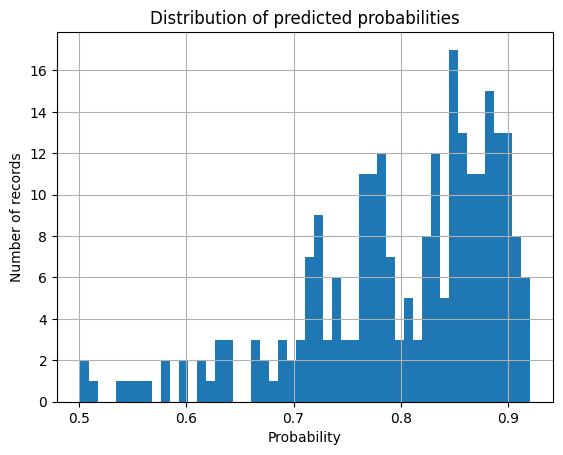

In [ ]:


plt.hist(outputs, bins=50)
plt.title("Distribution of predicted probabilities")
plt.xlabel("Probability")
plt.ylabel("Number of records")
plt.grid(True)
plt.show()


In [ ]:
# Capacity is 5% of total records
capacity = int(0.05 * len(labels))
top_k_indices = np.argsort(outputs)[::-1][:capacity]

# Debug: Show top-k records and if they are positive
for idx in top_k_indices:
    print(f"Index {idx}: prob={outputs[idx]:.4f}, label={labels[idx]}")


Index 31: prob=0.9205, label=1
Index 55: prob=0.9194, label=1
Index 50: prob=0.9171, label=1
Index 57: prob=0.9169, label=1
Index 92: prob=0.9158, label=1
Index 149: prob=0.9158, label=1
Index 201: prob=0.9118, label=1
Index 26: prob=0.9071, label=1
Index 78: prob=0.9070, label=1
Index 205: prob=0.9067, label=1
Index 197: prob=0.9064, label=1
Index 153: prob=0.9059, label=1


In [ ]:
# Indices of all true positive samples
tp_indices = np.where(labels == 1)[0]

# Find which of them are NOT in top_k
missed_tp = [idx for idx in tp_indices if idx not in top_k_indices]

print(f"Missed true positives (not in top 5%): {len(missed_tp)}")
for idx in missed_tp:
    print(f"Index {idx}: prob={outputs[idx]:.4f}")


Missed true positives (not in top 5%): 181
Index 6: prob=0.6999
Index 8: prob=0.6764
Index 10: prob=0.6688
Index 14: prob=0.6748
Index 17: prob=0.6775
Index 21: prob=0.6541
Index 27: prob=0.6889
Index 28: prob=0.7188
Index 30: prob=0.7378
Index 32: prob=0.7667
Index 33: prob=0.7399
Index 36: prob=0.6832
Index 37: prob=0.7228
Index 38: prob=0.7675
Index 39: prob=0.7820
Index 41: prob=0.7210
Index 42: prob=0.7478
Index 44: prob=0.6784
Index 48: prob=0.6870
Index 49: prob=0.7677
Index 53: prob=0.7759
Index 54: prob=0.7931
Index 56: prob=0.7887
Index 58: prob=0.6730
Index 59: prob=0.6947
Index 61: prob=0.7177
Index 62: prob=0.7204
Index 63: prob=0.7911
Index 64: prob=0.7931
Index 65: prob=0.7689
Index 67: prob=0.6745
Index 68: prob=0.7478
Index 69: prob=0.7396
Index 70: prob=0.7534
Index 71: prob=0.6600
Index 72: prob=0.7706
Index 73: prob=0.7670
Index 74: prob=0.7212
Index 75: prob=0.7147
Index 76: prob=0.7062
Index 77: prob=0.6991
Index 80: prob=0.7469
Index 82: prob=0.6625
Index 83: pro

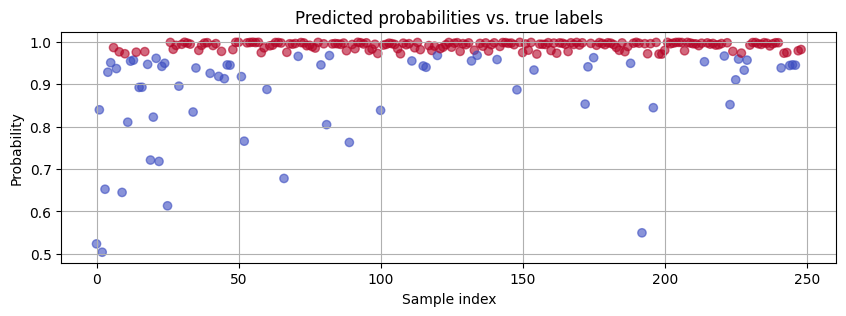

In [ ]:
plt.figure(figsize=(10, 3))
plt.scatter(range(len(outputs)), outputs, c=labels, cmap='coolwarm', alpha=0.6)
plt.title("Predicted probabilities vs. true labels")
plt.xlabel("Sample index")
plt.ylabel("Probability")
plt.grid(True)
plt.show()


# S4 Model

### Run

In [ ]:
!python run_model.py -d dataset -m model2 -o holdout_outputs_s4 -v

Loading the Challenge model...
Finding the Challenge data...
Running the Challenge model on the Challenge data...
-   1/249: 00002_hr...
🔍 final_model.pt: prob=0.0478 → Prediction=0
-   2/249: 00009_hr...
🔍 final_model.pt: prob=0.0196 → Prediction=0
-   3/249: 00018_hr...
🔍 final_model.pt: prob=0.6366 → Prediction=0
-   4/249: 00023_hr...
🔍 final_model.pt: prob=0.2277 → Prediction=0
-   5/249: 102640...
🔍 final_model.pt: prob=0.4770 → Prediction=0
-   6/249: 105443...
🔍 final_model.pt: prob=0.7525 → Prediction=1
-   7/249: 106689...
🔍 final_model.pt: prob=0.7093 → Prediction=1
-   8/249: 107019...
🔍 final_model.pt: prob=0.0593 → Prediction=0
-   9/249: 109838...
🔍 final_model.pt: prob=0.2131 → Prediction=0
-  10/249: 112408...
🔍 final_model.pt: prob=0.1436 → Prediction=0
-  11/249: 132616...
🔍 final_model.pt: prob=0.1509 → Prediction=0
-  12/249: 138534...
🔍 final_model.pt: prob=0.2175 → Prediction=0
-  13/249: 138704...
🔍 final_model.pt: prob=0.5538 → Prediction=0
-  14/249: 141879...

### Evaluate

In [ ]:
!python evaluate_model.py -d dataset -o holdout_outputs_s4 -s scores.csv

### Metrics & Analysis

In [ ]:


# === Step 1: Load labels and predictions
labels, outputs = load_predictions_and_labels("holdout_outputs_s4")

# === Step 2: Calculate metrics using helper_code
challenge_score = compute_challenge_score(labels, outputs)
auroc, auprc = compute_auc(labels, outputs)
predicted_labels = (outputs >= 0.5).astype(int)
accuracy = compute_accuracy(labels, predicted_labels)
f1 = compute_f_measure(labels, predicted_labels)

# === Step 3: Format nicely with pandas
df = pd.DataFrame({
    "Metric": ["Challenge score", "AUROC", "AUPRC", "Accuracy", "F-measure"],
    "Score": [challenge_score, auroc, auprc, accuracy, f1]
})

# === Step 4: Display
df.style.set_properties(**{"text-align": "center"}).set_table_styles([{
    "selector": "th",
    "props": [("text-align", "center")]
}])


,Metric,Score
0,Challenge score,0.067039
1,AUROC,1.000000
2,AUPRC,1.000000
3,Accuracy,0.983936
4,F-measure,0.983788


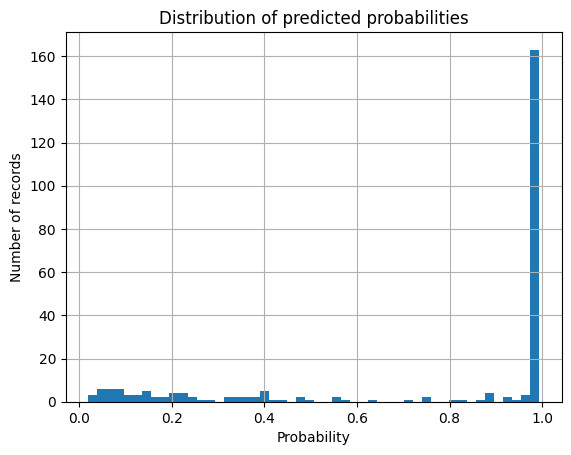

In [ ]:
import matplotlib.pyplot as plt

plt.hist(outputs, bins=50)
plt.title("Distribution of predicted probabilities")
plt.xlabel("Probability")
plt.ylabel("Number of records")
plt.grid(True)
plt.show()


In [ ]:
# Capacity is 5% of total records
capacity = int(0.05 * len(labels))
top_k_indices = np.argsort(outputs)[::-1][:capacity]

# Debug: Show top-k records and if they are positive
for idx in top_k_indices:
    print(f"Index {idx}: prob={outputs[idx]:.4f}, label={labels[idx]}")


Index 240: prob=0.9938, label=1
Index 233: prob=0.9938, label=1
Index 231: prob=0.9938, label=1
Index 237: prob=0.9938, label=1
Index 198: prob=0.9938, label=1
Index 215: prob=0.9938, label=1
Index 209: prob=0.9938, label=1
Index 216: prob=0.9938, label=1
Index 222: prob=0.9938, label=1
Index 205: prob=0.9938, label=1
Index 203: prob=0.9938, label=1
Index 201: prob=0.9938, label=1


In [ ]:
# Indices of all true positive samples
tp_indices = np.where(labels == 1)[0]

# Find which of them are NOT in top_k
missed_tp = [idx for idx in tp_indices if idx not in top_k_indices]

print(f"Missed true positives (not in top 5%): {len(missed_tp)}")
for idx in missed_tp:
    print(f"Index {idx}: prob={outputs[idx]:.4f}")


Missed true positives (not in top 5%): 167
Index 5: prob=0.7525
Index 6: prob=0.7093
Index 16: prob=0.7993
Index 26: prob=0.9930
Index 27: prob=0.9922
Index 30: prob=0.9922
Index 31: prob=0.9930
Index 32: prob=0.9938
Index 33: prob=0.9892
Index 37: prob=0.9938
Index 38: prob=0.9922
Index 39: prob=0.9922
Index 41: prob=0.9899
Index 42: prob=0.9930
Index 44: prob=0.9378
Index 47: prob=0.9895
Index 49: prob=0.9938
Index 50: prob=0.9938
Index 52: prob=0.9938
Index 53: prob=0.9938
Index 54: prob=0.9938
Index 55: prob=0.9930
Index 56: prob=0.9930
Index 57: prob=0.9930
Index 59: prob=0.9922
Index 61: prob=0.9938
Index 62: prob=0.8281
Index 63: prob=0.9930
Index 64: prob=0.9930
Index 65: prob=0.9938
Index 67: prob=0.9228
Index 68: prob=0.9938
Index 69: prob=0.9938
Index 70: prob=0.9938
Index 72: prob=0.9938
Index 73: prob=0.9930
Index 74: prob=0.9922
Index 75: prob=0.9930
Index 76: prob=0.9938
Index 77: prob=0.9922
Index 78: prob=0.9938
Index 79: prob=0.9892
Index 80: prob=0.9917
Index 83: pro

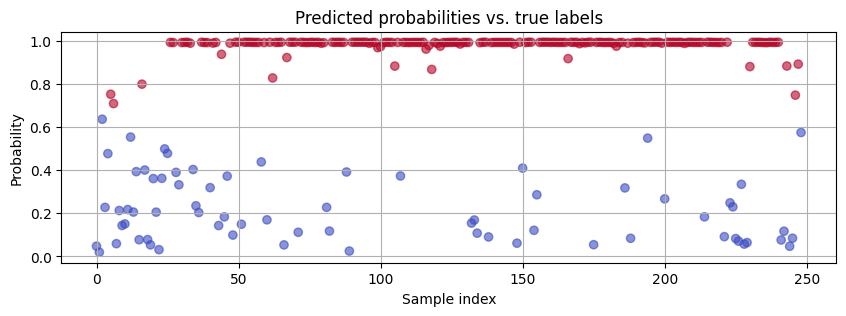

In [ ]:
plt.figure(figsize=(10, 3))
plt.scatter(range(len(outputs)), outputs, c=labels, cmap='coolwarm', alpha=0.6)
plt.title("Predicted probabilities vs. true labels")
plt.xlabel("Sample index")
plt.ylabel("Probability")
plt.grid(True)
plt.show()


# Comparison between ensemble model and S4 model

In [ ]:
def evaluate_model(pred_path: str):
    # Load labels and predicted probabilities
    labels, outputs = load_predictions_and_labels(pred_path)

    # Compute metrics
    challenge_score = compute_challenge_score(labels, outputs)
    auroc, auprc = compute_auc(labels, outputs)
    predicted_labels = (outputs >= 0.5).astype(int)
    accuracy = compute_accuracy(labels, predicted_labels)
    f1 = compute_f_measure(labels, predicted_labels)

    return {
        "Challenge score": challenge_score,
        "AUROC": auroc,
        "AUPRC": auprc,
        "Accuracy": accuracy,
        "F-measure": f1
    }

# === Evaluate both models
s4_scores = evaluate_model("holdout_outputs_s4")
ens_scores = evaluate_model("holdout_outputs_ens")

# === Combine into a DataFrame
comparison_df = pd.DataFrame({
    "Metric": list(s4_scores.keys()),
    "S4D_final_model.pt": list(s4_scores.values()),
    "Ensemble_model.pt": [ens_scores[m] for m in s4_scores.keys()]
})

# === Display the tidy table
comparison_df.set_index("Metric", inplace=True)
display(comparison_df)

,S4D_final_model.pt,Ensemble_model.pt
Metric,,
Challenge score,0.067039,0.052402
AUROC,1.000000,1.000000
AUPRC,1.000000,1.000000
Accuracy,0.983936,0.919679
F-measure,0.983788,0.881198
